In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
!pip install segmentation-models-pytorch ttach

     |████████████████████████████████| 42 kB 576 kB/s eta 0:00:011
     |████████████████████████████████| 58 kB 2.7 MB/s eta 0:00:011
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.6.3-py3-none-any.whl size=12419 sha256=cc7d895e5f09e2e860bed08e28b29050f6d6385a5f853f124382a0ccfea570b2
  Stored in directory: /root/.cache/pip/wheels/90/6b/0c/f0ad36d00310e65390b0d4c9218ae6250ac579c92540c9097a
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60962 sha256=85e082c6174421c91269f94c319a851ebb376d3b3a173c54c8167cb3c047ae93
  Stored in directory: /root/.cache/pip/wheels/ed/27/e8/9543d42de2740d3544db96aefef63bda3f2c1761b3334f4873
Successfully built efficientnet-pytorch pretrainedmodels


In [2]:
!pip install --pre torch==1.7.0.dev20200701+cu101 torchvision==0.8.0.dev20200701+cu101 -f https://download.pytorch.org/whl/nightly/cu101/torch_nightly.html

Looking in links: https://download.pytorch.org/whl/nightly/cu101/torch_nightly.html
     |████████████████████████████████| 844.4 MB 11 kB/s s eta 0:00:01   |▏                               | 3.6 MB 20.6 MB/s eta 0:00:41   |▎                               | 6.3 MB 20.6 MB/s eta 0:00:41     |▍                               | 9.8 MB 20.6 MB/s eta 0:00:41     |▌                               | 12.2 MB 20.6 MB/s eta 0:00:41 MB 20.6 MB/s eta 0:00:41     |▉                               | 22.0 MB 20.6 MB/s eta 0:00:40     |█████████▌                      | 250.7 MB 49.3 MB/s eta 0:00:13     |██████████                      | 261.0 MB 49.3 MB/s eta 0:00:12     |██████████                      | 262.2 MB 49.3 MB/s eta 0:00:12    | 546.5 MB 9.9 MB/s eta 0:00:31     |████████████████████▊           | 547.8 MB 9.9 MB/s eta 0:00:31     |█████████████████████▏          | 557.2 MB 50.3 MB/s eta 0:00:06�█▏ | 797.2 MB 42.4 MB/s eta 0:00:02     |███████████████████████████████▍| 827.5 MB 46.3 MB/s eta 

In [3]:
import wandb
wandb.login(key='44b74d6614becfad4329893ea0144da65336bdbd')

is_fp16_used = True

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publically.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: WARNING Calling wandb.login() without arguments from jupyter should prompt you for an api key.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [4]:
from typing import Callable, List, Tuple

import os
import torch
import catalyst

from catalyst.dl import utils

print(f"torch: {torch.__version__}, catalyst: {catalyst.__version__}")

os.environ["CUDA_VISIBLE_DEVICES"] = "0"  # "" - CPU, "0" - 1 GPU, "0,1" - MultiGPU

SEED = 42
utils.set_global_seed(SEED)
utils.prepare_cudnn(deterministic=True)

/opt/conda/lib/python3.7/site-packages/tqdm/std.py:666: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


torch: 1.7.0.dev20200701+cu101, catalyst: 20.07


In [5]:
from pathlib import Path

ROOT = Path("../input/semantic-drone-dataset/semantic_drone_dataset/")

train_image_path = ROOT / "original_images"
train_mask_path = ROOT / "label_images_semantic"

ALL_IMAGES = sorted(train_image_path.glob("*.jpg"))
len(ALL_IMAGES)

ALL_MASKS = sorted(train_mask_path.glob("*.png"))
len(ALL_MASKS)

400

In [6]:
import random
import matplotlib.pyplot as plt
import numpy as np
from skimage.io import imread as gif_imread
from catalyst import utils


def show_examples(name: str, image: np.ndarray, mask: np.ndarray):
    plt.figure(figsize=(10, 14))
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title(f"Image: {name}")

    plt.subplot(1, 2, 2)
    plt.imshow(mask)
    plt.title(f"Mask: {name}")


def show(index: int, images: List[Path], masks: List[Path], transforms=None) -> None:
    image_path = images[index]
    name = image_path.name

    image = utils.imread(image_path)
    mask = gif_imread(masks[index])

    if transforms is not None:
        temp = transforms(image=image, mask=mask)
        image = temp["image"]
        mask = temp["mask"]

    show_examples(name, image, mask)

def show_random(images: List[Path], masks: List[Path], transforms=None) -> None:
    length = len(images)
    index = random.randint(0, length - 1)
    show(index, images, masks, transforms)

In [7]:
from typing import List

from torch.utils.data import Dataset


class SegmentationDataset(Dataset):
    def __init__(
        self,
        images: List[Path],
        masks: List[Path] = None,
        transforms=None
    ) -> None:
        self.images = images
        self.masks = masks
        self.transforms = transforms

    def __len__(self) -> int:
        return len(self.images)

    def __getitem__(self, idx: int) -> dict:
        image_path = self.images[idx]
        image = utils.imread(image_path)
        
        result = {"image": image}
        
        if self.masks is not None:
            mask = gif_imread(self.masks[idx])
            result["mask"] = mask
        
        if self.transforms is not None:
            result = self.transforms(**result)
        
        result["filename"] = image_path.name

        return result

In [8]:
import albumentations as albu
from albumentations.pytorch import ToTensor


def pre_transforms():
    return [albu.Resize(512, 768, p=1),
           albu.PadIfNeeded(min_height=768, min_width=768, always_apply=True, border_mode=0)]


def hard_transforms():
    result = [
        albu.HorizontalFlip(p=0.5),
        albu.VerticalFlip(p=0.5),
        albu.OneOf([
            albu.RandomBrightnessContrast(
              brightness_limit=0.4, contrast_limit=0.4, p=1),
            albu.CLAHE(p=1),
        ],
        p=1,
        ),
        albu.HueSaturationValue(p=0.3)
    ]

    return result
  
def post_transforms():
    # we use ImageNet image normalization
    # and convert it to torch.Tensor
    return [albu.Normalize(), ToTensor()]
  
def compose(transforms_to_compose):
    # combine all augmentations into single pipeline
    result = albu.Compose([
      item for sublist in transforms_to_compose for item in sublist
    ])
    return result

In [9]:
train_transforms = compose([
    pre_transforms(), 
    hard_transforms(),
    post_transforms()
])
valid_transforms = compose([pre_transforms(), post_transforms()])

show_transforms = compose([pre_transforms(), hard_transforms()])

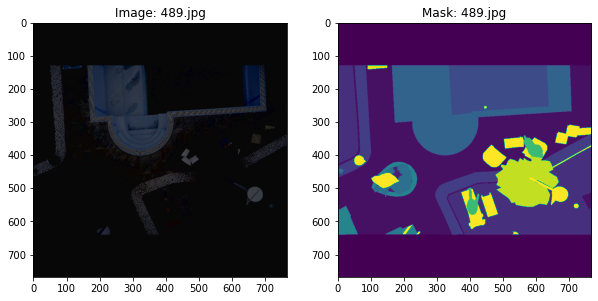

In [10]:
show_random(ALL_IMAGES, ALL_MASKS, transforms=show_transforms)

In [11]:
import collections
from sklearn.model_selection import train_test_split

from torch.utils.data import DataLoader

def get_loaders(
    images: List[Path],
    masks: List[Path],
    random_state: int,
    valid_size: float = 0.25,
    batch_size: int = 6,
    num_workers: int = 4,
    train_transforms_fn = None,
    valid_transforms_fn = None,
) -> dict:

    indices = np.arange(len(images))

    # Let's divide the data set into train and valid parts.
    train_indices, valid_indices = train_test_split(
      indices, test_size=valid_size, random_state=random_state, shuffle=True
    )

    np_images = np.array(images)
    np_masks = np.array(masks)

    # Creates our train dataset
    train_dataset = SegmentationDataset(
      images = np_images[train_indices].tolist(),
      masks = np_masks[train_indices].tolist(),
      transforms = train_transforms_fn
    )

    # Creates our valid dataset
    valid_dataset = SegmentationDataset(
      images = np_images[valid_indices].tolist(),
      masks = np_masks[valid_indices].tolist(),
      transforms = valid_transforms_fn
    )

    # Catalyst uses normal torch.data.DataLoader
    train_loader = DataLoader(
      train_dataset,
      batch_size=batch_size,
      shuffle=True,
      num_workers=num_workers,
      drop_last=True,
    )

    valid_loader = DataLoader(
      valid_dataset,
      batch_size=batch_size,
      shuffle=False,
      num_workers=num_workers,
      drop_last=False,
    )

    # And excpect to get an OrderedDict of loaders
    loaders = collections.OrderedDict()
    loaders["train"] = train_loader
    loaders["valid"] = valid_loader

    return loaders

In [12]:
loaders = get_loaders(
    images=ALL_IMAGES,
    masks=ALL_MASKS,
    random_state=SEED,
    train_transforms_fn=train_transforms,
    valid_transforms_fn=valid_transforms
)

In [13]:
import segmentation_models_pytorch as smp
#model = smp.FPN(encoder_name='efficientnet-b3', classes=20)
# We will use Feature Pyramid Network with pre-trained ResNeXt50 backbone
model = smp.FPN(encoder_name="resnext50_32x4d", classes=20)
#model = smp.Unet(encoder_name="resnext50_32x4d", classes=20)

Downloading: "https://download.pytorch.org/models/resnext50_32x4d-7cdf4587.pth" to /root/.cache/torch/hub/checkpoints/resnext50_32x4d-7cdf4587.pth


In [14]:
from torch import nn

from catalyst.contrib.nn import DiceLoss, IoULoss

# we have multiple criterions
criterion = {
    "dice": DiceLoss(),
    "iou": IoULoss()
    #"foc": FocalLossMultiClass()
}

In [15]:
from catalyst.dl import SupervisedRunner

num_epochs = 15
logdir = "."

device = utils.get_device()
print(f"device: {device}")

if is_fp16_used:
    fp16_params = dict(opt_level="O1") # params for FP16
else:
    fp16_params = None

print(f"FP16 params: {fp16_params}")


# by default SupervisedRunner uses "features" and "targets",
# in our case we get "image" and "mask" keys in dataset __getitem__
runner = SupervisedRunner(device=device, input_key="image", input_target_key="mask")

device: cuda
FP16 params: {'opt_level': 'O1'}


In [16]:
from torch import optim

from catalyst.contrib.nn import RAdam, Lookahead, OneCycleLRWithWarmup

#learning_rate = 0.0007
#encoder_learning_rate = 0.0005

base_optimizer = RAdam([
    {'params': model.decoder.parameters(), 'lr': 1e-3}, 
    {'params': model.encoder.parameters(), 'lr': 5e-4},  
])

# Since we use a pre-trained encoder, we will reduce the learning rate on it.
#layerwise_params = {"encoder*": dict(lr=encoder_learning_rate)}#, weight_decay=0.00003)}

# This function removes weight_decay for biases and applies our layerwise_params
#model_params = utils.process_model_params(model, layerwise_params=layerwise_params)

# Catalyst has new SOTA optimizers out of box
#base_optimizer = RAdam(model_params, lr=learning_rate)#, weight_decay=0.0003)
optimizer = Lookahead(base_optimizer)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.4, patience=2, mode='max')
#scheduler = OneCycleLRWithWarmup(
#    optimizer, 
#    num_steps=num_epochs, 
#    lr_range=(0.002, 0.00001),
#    init_lr = learning_rate,
#    warmup_steps=2
#)

In [17]:
from catalyst.dl.callbacks import DiceCallback, IouCallback, \
  CriterionCallback, MetricAggregationCallback, WandbLogger#, OptimizerCallback

callbacks = [
    # Each criterion is calculated separately.
    CriterionCallback(
        input_key="mask",
        prefix="loss_dice",
        criterion_key="dice"
    ),
    CriterionCallback(
        input_key="mask",
        prefix="loss_iou",
        criterion_key="iou"
    ),
    #CriterionCallback(
    #    input_key="mask",
    #    prefix="loss_foc",
    #    criterion_key="foc"
    #),

    # And only then we aggregate everything into one loss.
    MetricAggregationCallback(
        prefix="loss",
        mode="weighted_sum", # can be "sum", "weighted_sum" or "mean"
        # because we want weighted sum, we need to add scale for each loss
        metrics={"loss_dice": 1.0, "loss_iou": 1.0},#, "loss_foc": 0.8},
    ),

    # metrics
    DiceCallback(input_key="mask"),
    IouCallback(input_key="mask"),
    
    #OptimizerCallback(accumulation_steps=2),
    
    WandbLogger(project='X', name='10')
]


runner.train(
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    # our dataloaders
    loaders=loaders,
    # We can specify the callbacks list for the experiment;
    callbacks=callbacks,
    # path to save logs
    logdir=logdir,
    num_epochs=num_epochs,
    # save our best checkpoint by IoU metric
    main_metric="iou",
    # IoU needs to be maximized.
    minimize_metric=False,
    # for FP16. It uses the variable from the very first cell
    fp16=fp16_params,
    # prints train logs
    verbose=True,
)

wandb: Wandb version 0.9.4 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


1/15 * Epoch (train):   2% 1/50 [00:18<15:25, 18.88s/it, dice=0.021, iou=0.011, loss=1.968, loss_dice=0.979, loss_iou=0.989]

/opt/conda/lib/python3.7/site-packages/catalyst/contrib/nn/optimizers/radam.py:85: UserWarning:

This overload of addcmul_ is deprecated:
	addcmul_(Number value, Tensor tensor1, Tensor tensor2)
Consider using one of the following signatures instead:
	addcmul_(Tensor tensor1, Tensor tensor2, *, Number value) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:766.)



1/15 * Epoch (train): 100% 50/50 [02:59<00:00,  3.59s/it, dice=0.044, iou=0.023, loss=1.933, loss_dice=0.956, loss_iou=0.977]
1/15 * Epoch (valid): 100% 17/17 [00:58<00:00,  3.41s/it, dice=0.054, iou=0.028, loss=1.919, loss_dice=0.946, loss_iou=0.972]
[2020-07-25 09:44:22,514] 
1/15 * Epoch 1 (_base): lr=0.0010 | momentum=0.9000
1/15 * Epoch 1 (train): dice=0.0345 | iou=0.0176 | loss=1.9479 | loss_dice=0.9655 | loss_iou=0.9824
1/15 * Epoch 1 (valid): dice=0.0492 | iou=0.0252 | loss=1.9256 | loss_dice=0.9508 | loss_iou=0.9748
2/15 * Epoch (train): 100% 50/50 [02:58<00:00,  3.58s/it, dice=0.052, iou=0.027, loss=1.921, loss_dice=0.948, loss_iou=0.973]
2/15 * Epoch (valid): 100% 17/17 [00:56<00:00,  3.30s/it, dice=0.074, iou=0.038, loss=1.888, loss_dice=0.926, loss_iou=0.962]
[2020-07-25 09:48:20,371] 
2/15 * Epoch 2 (_base): lr=0.0010 | momentum=0.9000
2/15 * Epoch 2 (train): dice=0.0604 | iou=0.0312 | loss=1.9085 | loss_dice=0.9396 | loss_iou=0.9688
2/15 * Epoch 2 (valid): dice=0.0765 | 

In [ ]:
batch = next(iter(loaders["valid"]))
batch
threshold = 0.5

image = utils.tensor_to_ndimage(batch["image"][0])

mask_ = tta_predictions["logits"][0, 0].sigmoid()
mask = utils.detach(mask_ > threshold).astype("float")

show_examples(name="", image=image, mask=mask)